In [1]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
import time
import pandas as pd
import seaborn as sn
import keras
import os
import cv2
import pickle
import random
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib
# matplotlib.use("Agg")

Using TensorFlow backend.


In [2]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 400
INIT_LR = 1e-2
BS = 32
IMAGE_DIMS = (224, 224, 3)

In [3]:
from imutils import paths

imagePaths = sorted(list(paths.list_images("anger_classification_minority_duplicated")))
random.seed(42)
random.shuffle(imagePaths)
imagePaths

['anger_classification_minority_duplicated\\anger\\anger_127.jpg',
 'anger_classification_minority_duplicated\\non_anger\\non_anger_266.jpg',
 'anger_classification_minority_duplicated\\non_anger\\non_anger_291.jpg',
 'anger_classification_minority_duplicated\\anger\\anger_416 - Copy.jpg',
 'anger_classification_minority_duplicated\\non_anger\\non_anger_761.jpg',
 'anger_classification_minority_duplicated\\non_anger\\non_anger_2000.jpg',
 'anger_classification_minority_duplicated\\non_anger\\non_anger_451.jpg',
 'anger_classification_minority_duplicated\\non_anger\\non_anger_1167.jpg',
 'anger_classification_minority_duplicated\\anger\\anger_166 - Copy (2).jpg',
 'anger_classification_minority_duplicated\\anger\\anger_369 - Copy (2).jpg',
 'anger_classification_minority_duplicated\\non_anger\\non_anger_816.jpg',
 'anger_classification_minority_duplicated\\anger\\anger_299 - Copy (2).jpg',
 'anger_classification_minority_duplicated\\anger\\anger_335 - Copy.jpg',
 'anger_classification_m

In [4]:
from keras.preprocessing.image import img_to_array

data = []
labels = []

# loop over the input images
for imagePath in imagePaths:
    # load the image, pre-process it, and store it in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

    # extract the class label from the image path and update the
    # labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

In [5]:
# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
    data.nbytes / (1024 * 1000.0)))

[INFO] data matrix: 5247.31MB


In [6]:
from sklearn.preprocessing import LabelBinarizer

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [7]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)

In [8]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [9]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

class SmallerVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be
        # "channels last" and the channels dimension itself
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL
        model.add(Conv2D(32, (3, 3), padding="same",
            input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(3, 3)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))
        
        # (CONV => RELU) * 2 => POOL
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(256, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(1024))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [10]:
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
    depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] done compiling.")

[INFO] compiling model...
[INFO] done compiling.


In [11]:
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

In [12]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY),
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1)#, class_weight={0:3, 1:1})

# save the model to disk
print("[INFO] serializing network...")
model.save("anger_minority_duplicated_SmallVGG_400_epochs.model")

[INFO] training network...
Epoch 1/400
111/111 [==============================] - 33s 297ms/step - loss: 1.5909 - accuracy: 0.5205 - val_loss: 8.4986 - val_accuracy: 0.4938
Epoch 2/400
111/111 [==============================] - 28s 253ms/step - loss: 1.4155 - accuracy: 0.5304 - val_loss: 1.5705 - val_accuracy: 0.4423
Epoch 3/400
111/111 [==============================] - 28s 253ms/step - loss: 1.2620 - accuracy: 0.5228 - val_loss: 0.8140 - val_accuracy: 0.5241
Epoch 4/400
111/111 [==============================] - 28s 251ms/step - loss: 1.0833 - accuracy: 0.5434 - val_loss: 0.8755 - val_accuracy: 0.5230
Epoch 5/400
111/111 [==============================] - 28s 251ms/step - loss: 1.1415 - accuracy: 0.5605 - val_loss: 2.2775 - val_accuracy: 0.5017
Epoch 6/400
111/111 [==============================] - 28s 248ms/step - loss: 1.0434 - accuracy: 0.5442 - val_loss: 5.2109 - val_accuracy: 0.5196
Epoch 7/400
111/111 [==============================] - 28s 248ms/step - loss: 0.9353 - accuracy: 

Epoch 112/400
111/111 [==============================] - 27s 245ms/step - loss: 0.5083 - accuracy: 0.7639 - val_loss: 0.6291 - val_accuracy: 0.6887
Epoch 113/400
111/111 [==============================] - 27s 244ms/step - loss: 0.5132 - accuracy: 0.7554 - val_loss: 0.7304 - val_accuracy: 0.6719
Epoch 114/400
111/111 [==============================] - 28s 256ms/step - loss: 0.5225 - accuracy: 0.7549 - val_loss: 1.1971 - val_accuracy: 0.5476
Epoch 115/400
111/111 [==============================] - 28s 255ms/step - loss: 0.4973 - accuracy: 0.7659 - val_loss: 0.7153 - val_accuracy: 0.6159
Epoch 116/400
111/111 [==============================] - 28s 252ms/step - loss: 0.4942 - accuracy: 0.7710 - val_loss: 0.5984 - val_accuracy: 0.6887
Epoch 117/400
111/111 [==============================] - 28s 252ms/step - loss: 0.4967 - accuracy: 0.7696 - val_loss: 0.8772 - val_accuracy: 0.6965
Epoch 118/400
111/111 [==============================] - 28s 251ms/step - loss: 0.4823 - accuracy: 0.7747 - val_

111/111 [==============================] - 27s 247ms/step - loss: 0.2570 - accuracy: 0.8844 - val_loss: 0.7603 - val_accuracy: 0.7402
Epoch 223/400
111/111 [==============================] - 27s 246ms/step - loss: 0.2726 - accuracy: 0.8849 - val_loss: 0.5758 - val_accuracy: 0.8007
Epoch 224/400
111/111 [==============================] - 27s 246ms/step - loss: 0.2542 - accuracy: 0.8920 - val_loss: 0.9566 - val_accuracy: 0.6887
Epoch 225/400
111/111 [==============================] - 27s 247ms/step - loss: 0.2946 - accuracy: 0.8731 - val_loss: 0.6839 - val_accuracy: 0.7021
Epoch 226/400
111/111 [==============================] - 28s 256ms/step - loss: 0.2848 - accuracy: 0.8719 - val_loss: 2.1407 - val_accuracy: 0.5420
Epoch 227/400
111/111 [==============================] - 29s 257ms/step - loss: 0.2856 - accuracy: 0.8764 - val_loss: 0.6048 - val_accuracy: 0.7671
Epoch 228/400
111/111 [==============================] - 28s 254ms/step - loss: 0.2574 - accuracy: 0.8982 - val_loss: 0.5267 -

111/111 [==============================] - 27s 245ms/step - loss: 0.2214 - accuracy: 0.9039 - val_loss: 0.7833 - val_accuracy: 0.7447
Epoch 333/400
111/111 [==============================] - 27s 245ms/step - loss: 0.2212 - accuracy: 0.9118 - val_loss: 0.5995 - val_accuracy: 0.7973
Epoch 334/400
111/111 [==============================] - 27s 245ms/step - loss: 0.2181 - accuracy: 0.9036 - val_loss: 0.4950 - val_accuracy: 0.8175
Epoch 335/400
111/111 [==============================] - 27s 245ms/step - loss: 0.2180 - accuracy: 0.9059 - val_loss: 0.8238 - val_accuracy: 0.8343
Epoch 336/400
111/111 [==============================] - 27s 246ms/step - loss: 0.2153 - accuracy: 0.9078 - val_loss: 0.6954 - val_accuracy: 0.7458
Epoch 337/400
111/111 [==============================] - 27s 245ms/step - loss: 0.2249 - accuracy: 0.9042 - val_loss: 0.4604 - val_accuracy: 0.8331
Epoch 338/400
111/111 [==============================] - 28s 256ms/step - loss: 0.2153 - accuracy: 0.9061 - val_loss: 0.5391 -

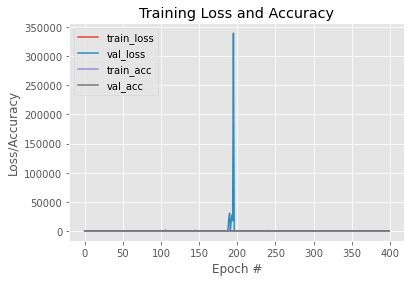

<Figure size 432x288 with 0 Axes>

In [13]:
plt.style.use("ggplot")
%matplotlib inline
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('anger_minority_duplicated_SmallVGG_400_epochs.png', dpi=100)

In [14]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 

# predict probabilities for test set
yhat_probs = model.predict(testX, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(testX, verbose=0)

Classification report: 
---------------------------------------------------------- 
              precision    recall  f1-score   support

       anger       0.76      0.96      0.85       448
   non-anger       0.94      0.69      0.80       445

    accuracy                           0.82       893
   macro avg       0.85      0.82      0.82       893
weighted avg       0.85      0.82      0.82       893

---------------------------------------------------------- 
Accuracy score: 0.824188
Precision score: 0.939024
Recall score: 0.692135
F1 score: 0.796895
---------------------------------------------------------- 
Confusion matrix: 
[[428  20]
 [137 308]]


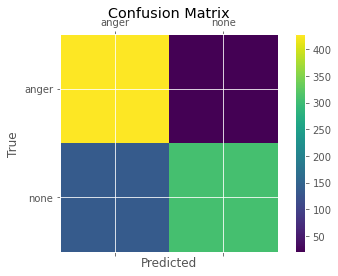

[[428  20]
 [137 308]]


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

classif_report = classification_report(testY, yhat_classes, target_names=['anger', 'non-anger'])
print('Classification report: ')
print('---------------------------------------------------------- ')
print(classif_report)

print('---------------------------------------------------------- ')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy score: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision score: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall score: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
print('---------------------------------------------------------- ')

# confusion matrix
labels = ['anger', 'none']
matrix = confusion_matrix(testY, yhat_classes)
print('Confusion matrix: ')
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_anger_minority_duplicated_SmallVGG_400_epochs.png')
plt.show()
print(matrix)